# Sentiment Analysis on Custom Text Dataset
This notebook trains and evaluates a logistic regression model on your `.txt` dataset for sentiment/emotion prediction.
Dataset is taken from: https://kristina.machova.website.tuke.sk/

In [13]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import pickle
import os

In [6]:
# 2. Load Data
def load_txt_data(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        lines = f.readlines()
    texts, labels = [], []
    for line in lines:
        if ";" in line:
            text, label = line.strip().rsplit(";", 1)
            texts.append(text)
            labels.append(label)
    return pd.DataFrame({"text": texts, "label": labels})

train_df = load_txt_data("data/Emotion/train dataset.txt")
test_df = load_txt_data("data/Emotion/test dataset.txt")
val_df = load_txt_data("data/Emotion/validation dataset.txt")
df = pd.concat([train_df, val_df], ignore_index=True)
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


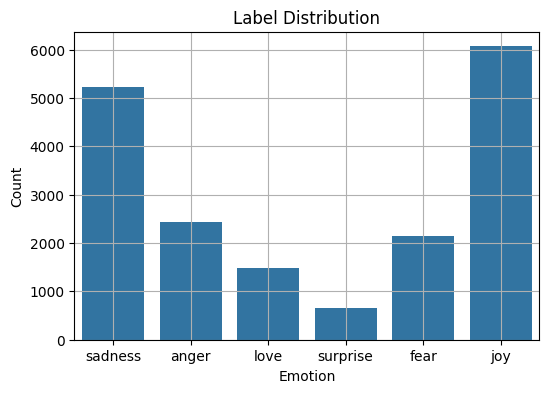

Text Length Stats:
 count    18000.000000
mean        96.679333
std         55.786339
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64


In [7]:
# 3. Visualize and Analyze
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.title("Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(True)
plt.show()

df["text_length"] = df["text"].apply(len)
print("Text Length Stats:\n", df["text_length"].describe())

In [8]:
# 4. Split Data
X_train, y_train = df["text"], df["label"]
X_test, y_test = test_df["text"], test_df["label"]

# 5. Build Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 6. Train Model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [15]:
# 7. Evaluate on Test Set
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

import json

emotion_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='weighted'),
    "recall": recall_score(y_test, y_pred, average='weighted'),
    "f1_score": f1_score(y_test, y_pred, average='weighted')
}

os.makedirs("models/emotion", exist_ok=True)

metrics_path = "models/emotion/emotion_metrics.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(emotion_metrics, f, indent=4)

print(f"Metrics saved to {metrics_path}")


Accuracy: 0.8955
Precision (weighted): 0.9078546208772508
Recall (weighted): 0.8955
F1 Score (weighted): 0.8984433961247553

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.92      0.90       275
        fear       0.90      0.84      0.87       224
         joy       0.95      0.88      0.91       695
        love       0.70      0.94      0.80       159
     sadness       0.96      0.91      0.94       581
    surprise       0.62      0.92      0.74        66

    accuracy                           0.90      2000
   macro avg       0.84      0.90      0.86      2000
weighted avg       0.91      0.90      0.90      2000

Metrics saved to models/emotion/emotion_metrics.json


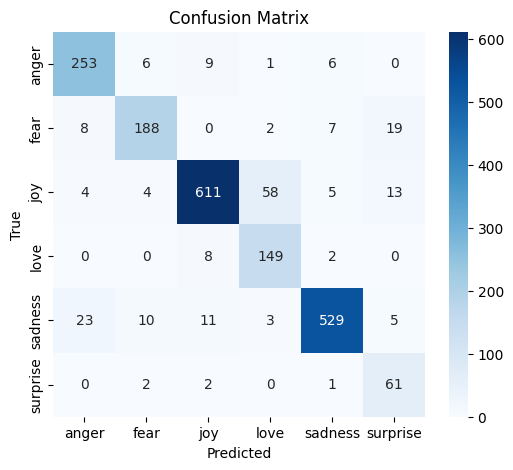

In [10]:
# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
# 9. Save Model and Vectorizer
os.makedirs("models/emotion", exist_ok=True)
with open("models/emotion/emotion_classifier.pkl", "wb") as f:
    pickle.dump(pipeline.named_steps["clf"], f)
with open("models/emotion/emotion_vectorizer.pkl", "wb") as f:
    pickle.dump(pipeline.named_steps["tfidf"], f)

print("Model and vectorizer saved to models/emotion/")

Model and vectorizer saved to models/emotion/


In [4]:
import pandas as pd
import json

# Load the CSV that has exactly two columns: 'text' and 'section'
df = pd.read_csv("data/ipc_sections_dataset.csv", dtype=str)

# Build a mapping: section → text
section_map = df.set_index("section")["text"].to_dict()

# Save it out
with open("data/section_map.json", "w", encoding="utf-8") as f:
    json.dump(section_map, f, indent=2, ensure_ascii=False)
